# Image Segmentation

The main objectives of this module are:

* Use & compare different methods of segmentation:
    * Histogram-based
    * Texture-based
    * Region growing
* Detect objects and extract object features.
* Understand corner detection and basic object recognition

## 1. Histogram segmentation

In histogram segmentation, we make the hypothesis that the histogram is composed of distinct separable distributions, and we try to find the best threshold to separate those distributions.

The code below uses a default threshold of 127 to segment the image. Modify it to:

1. Create a function to compute the optimal threshold for an 8 bit image. Apply on the cameraman image.
1. Compute the Otsu threshold for an 8-bit image, by optimizing within variance or inter-class variance for each possible theshold *t*. See [here](http://nbviewer.jupyter.org/github/odebeir/info-h-500-501/blob/ver_2016-2017/04-Image%20segmentation/01-Histogram%20based%20image%20segmentation.ipynb) how to compute the Otsu threshold.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imshow

def manual_threshold(im, T):
    return im>T
    
def optimal_threshold(h, T0):
    h1 = h[:T0]
    h2 = h[T0:]

    c1 = (h1*np.arange(0,T0)).sum()/h1.sum()
    c2 = (h2*np.arange(T0, len(h))).sum()/h2.sum()
    
    t2 = int(np.round((c1+c2)/2))
    if(t2 != T0): return optimal_threshold(h,t2)
    return t2
             
def otsu_threshold(im):
    h, bins = np.histogram(im, range(257))
    
    var_within = np.zeros(len(h))
    var_between = np.zeros(len(h))
    sep = np.zeros(len(h))
    
    for t in range(1, len(h)-1):
        w1 = h[:t].sum()
        w2 = h[t:].sum()
        
        m1 = (np.arange(0,t)*h[:t]).sum()/w1
        m2 = (np.arange(t, len(h))*h[t:]).sum()/w2
        
        s1 = (((np.arange(0,t)-m1)**2)*h[:t]).sum()/w1
        s2 = (((np.arange(t, len(h))-m2)**2)*h[t:]).sum()/w2
        
        sw = w1*s1 + w2*s2
        sb = w1*w2*((m2-m1)**2)
        
        l = sb/sw
        var_within[t] = sw
        var_between[t] = sb
        
        # print(var_between)
    sep[1:-1] = var_between[1:-1]/var_within[1:-1]
    best_t = np.argmax(sep)
    
    return best_t, var_within, var_between, sep 


In [ ]:
def plot_histogram_with_threshold(im, T):
    plt.figure(figsize=(15,5))
    h = plt.hist(im.flatten(), bins=range(256))
    plt.plot([T,T],[0,h[0].max()], 'r-')
    plt.show()

In [ ]:
im = imread('camera.jpg')

T = 127 
im_segmented = manual_threshold(im, T)


h, bins = np.histogram(im,range(257))    

t_optimal = optimal_threshold(h,T)
im_optimal = manual_threshold(im, t_optimal)

best_t, var_within, var_between, sep = otsu_threshold(im)
im_otsu = manual_threshold(im, best_t)

plot_histogram_with_threshold(im, T)
plot_histogram_with_threshold(im, t_optimal)
plot_histogram_with_threshold(im, best_t)

# Show original image & segmented binary image
plt.figure(figsize=(15,8))
plt.subplot(1,4,1)
imshow(im)
plt.subplot(1,4,2)
imshow(im_segmented)
plt.subplot(1,4,3)
imshow(im_optimal)
plt.subplot(1,4,3)
imshow(im_otsu)

plt.show()

**Need more help? You can check the following videos:**

* [Manual thresholding](https://www.youtube.com/watch?v=rgKkws_fqz4&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=24)
* [Optimal threshold](https://www.youtube.com/watch?v=7B1cs0PARtg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=25)
* [Otsu threshold](https://www.youtube.com/watch?v=mz26bssSLds&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=26)

## 2. Texture segmentation

Texture segmentation uses regional descriptors to segment the image based on the local texture. A simple algorithm is provided below, which:

* Extract neighborhoods with the sliding window method
* Compute the local maximum on the neighborhood and put it in a "descriptor" image
* Use Otsu thresholding on the descriptor image to segment it
* Display the results

In [ ]:
from skimage.filters.rank import entropy
from skimage.filters import threshold_otsu
from skimage.io import imread, imshow
from skimage import img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def texture_descriptor(N):
    e = N.max() # Replace with your descriptor
    return e

def sliding_window(im, PATCH_SIZE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch)
    return output

# Open zebra image as an 8-bit integer grayscale
im = img_as_ubyte(imread("zebra.jpg", as_gray=True))

im_descr = sliding_window(im,(120,160))
T = threshold_otsu(im_descr)
mask = im_descr>T

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
imshow(im)
plt.title('Original')
plt.subplot(1,3,2)
imshow(im_descr)
plt.title('Descriptor image')
plt.subplot(1,3,3)
imshow(im*mask)
plt.title('Result')
plt.show()

In [ ]:
from skimage.feature import graycomatrix, graycoprops

angles = [0,np.pi/4]
displacements = [200]

glcm = graycomatrix(im, displacements, angles, 256, normed = True)

contrast = graycoprops(glcm, 'contrast' )
homogeneity = graycoprops(glcm, 'dissimilarity')
dissimilarity = graycoprops(glcm, 'dissimilarity') 


plt.figure()
plt.subplot(1,2,1)
plt.imshow(glcm[:,:,0,0])
plt.title("Zebra - 0°")
plt.subplot(1,2,2)
plt.imshow(glcm[:,:,0,1])
plt.title("Zebra - 90°")
plt.show()



In [ ]:
from skimage.filters.rank import entropy
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


def texture_descriptor(N):
    angles = [1.0*np.pi/2]
    displacements = [75]

    glcm = graycomatrix(N, displacements, angles, 256, normed = True)

    contrast = graycoprops(glcm, 'contrast' )
    homogeneity = graycoprops(glcm, 'dissimilarity')
    dissimilarity = graycoprops(glcm, 'dissimilarity') 
    e = contrast*np.ones(N.shape)
    
    return e

def sliding_window(im, PATCH_SIZE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch)
    return output

# Open zebra image as an 8-bit integer grayscale
im = img_as_ubyte(imread("zebra.jpg", as_gray=True))

im_descr = sliding_window(im,(90,90))

# im_descr = resize(im_descr.sum(axis=1), im.shape[:1], order = 2, mode='reflect')

T = threshold_otsu(im_descr)
mask = im_descr>T

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
imshow(im)
plt.title('Original')
plt.subplot(1,3,2)
imshow(im_descr)
plt.title('Descriptor image')
plt.subplot(1,3,3)
imshow(im*mask)
plt.title('Result')
plt.show()

Using the above example as a starting point, replace the "maximum" texture descriptor by properties from the co-occurrence matrix:
* Compute the co-occurrence matrix on the neighborhood (see [greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix)). Test different angles & displacements.
* Test different properties (see [greycoprops](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops))

Try to segment the zebra image as best as you can using those descriptors.

**Need more help? You can check the following videos:**

* [Region descriptors](https://www.youtube.com/watch?v=5F9aPiab8PA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=27)
* [Properties of the co-occurrence matrix](https://www.youtube.com/watch?v=NR3vrkZ9tyg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=28)
* [Texture segmentation](https://www.youtube.com/watch?v=b-SGhLu-R0c&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=29)

## 3. Region growing

In region growing algorithms, we start from "markers" which act as seed points, and grow the segmented regions from those markers. A well-known region-growing algorithm uses the watershed transform. The example below uses the watershed transform on the cameraman image, with hand-picked markers:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread

im = imread('camera.jpg')

smoothing_factor = 4
# Compute the gradients of the image:
gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))

# Hand-picked markers for the road image
markers_coordinates = [
    [10,256], # sky
    [200,150],# cameraman
    [400,20], # grass (left)
    [400,450] # grass (right)
]

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(gradient, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray);
plt.subplot(2,2,3)
plt.imshow(ws);
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));

Adapt this method to work on the road image.

Can you find a way to automatically determine the markers?

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage
from skimage.io import imread,imshow,imsave
from skimage.filters import gaussian, median
import skimage.filters.rank as skr
from skimage.morphology import disk

im0 = imread('road.jpg')

imshow(im0)

# im1 = skimage.color.rgb2hsv(im0)
im = im0[:,:,2]
imshow(im)

smoothing_factor = 4
# Compute the gradients of the image:
gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))

# Hand-picked markers for the road image
markers_coordinates = [
    [200,500], # sky
    [500,500],# road
    [400,100], # grass (left)
    [400,850], # grass (right)
    [600,475]
]

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(gradient, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray);
plt.subplot(2,2,3)
plt.imshow(ws);
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im0[:,:,2],ws));


Another use of the watershed transform is to separate overlapping object, as in the image below.

* Compute the [distance transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html#scipy.ndimage.distance_transform_edt) of the image.
* Use the result to automatically find good markers.
* Use the watershed transform to separate the three objects.

In [ ]:
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray
from skimage.io import imread,imshow,imsave
import numpy as np
import skimage.filters.rank as skr
from skimage.morphology import disk

im = rgb2gray(imread('separ.png'))==0
        
#Distance transform 

dist = distance_transform_edt(im)

n = 3
val = np.zeros((4,2))

smoothing_factor = 2

# Compute the gradients of the image:

val[3] = [100,100]

while(n > 0):
    pos = np.unravel_index(dist.argmax(), dist.shape)
    val[n-1] = pos
    dist[pos[0]-15:pos[0]+15,pos[1]-15:pos[1]+15] = 0
    n-=1
    
# imshow(dist)
dist = distance_transform_edt(im)

gradient_dist = skr.gradient(skr.mean(dist/dist.max(), disk(smoothing_factor)), disk(1))
gradient_im = skr.gradient(skr.mean(im.astype(int), disk(smoothing_factor)), disk(1))

markers = np.zeros(im.shape)

for i in range(4):
    markers[val[i][0].astype(int),val[i][1].astype(int)] = i + 1
    
ws = watershed(gradient_im, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(dist,cmap=plt.cm.gray);
plt.title('Distance map')
plt.subplot(2,2,3)
plt.imshow(ws);
plt.title('Watershed result')
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));



**Need more help? You can check the following videos:**

* [Markers for region growing](https://www.youtube.com/watch?v=3e0-rE9zhFk&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=30)
* [Watershed transform](https://www.youtube.com/watch?v=GuVp7dlzEKE&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=31)
* [Distance transform](https://www.youtube.com/watch?v=s1eABOdNnVg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=32)

## 4. Object features

The next step after segmentation is often to extract object features in order to recognize, classify, or measure information about the objects.

Starting from the example below:

1. **Extract connected components** (see [label()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=label#skimage.measure.label)) of the shapes image and **display the centroid of the objects** (see [regionprops()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops))
1. For each image label, **extract the coordinates of the contour** (see [find_contours()](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours)) and **find the corners** of each objects.
1. Suggest a method to **classify the objects** in different categories.

In [ ]:
from skimage.measure import label, regionprops,find_contours
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray
from skimage.io import imread,imshow,imsave
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters.rank as skr
from skimage.morphology import disk
import math
from skimage.feature import corner_harris, corner_subpix, corner_peaks

def angle(v1, v2):
  return np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))


im = (imread('shapes.png')[:,:,0]>0).astype(int) #binarize & cast to integer to make it easier to process later

## -- Labels -- ##
lab = label(im)


## -- Find centroids -- ##
prop = regionprops(lab)
centroid = np.zeros(im.shape)

c = np.zeros((len(prop),2))
X = np.zeros((len(prop)))
Y = np.zeros((len(prop)))
for i in range(c.shape[0]): 
    # c[i-1] = prop[i-1].centroid
    X[i-1] = prop[i-1].centroid[1]
    Y[i-1] = prop[i-1].centroid[0]
    
    
c_matrix = np.zeros(im.shape)    
for i in range(c.shape[0]): 
    c_matrix[c[i-1][0].astype(int),c[i-1][1].astype(int) ] = 1    


## -- Test pour tous -- ## 
  
contour = find_contours(lab,0)

contour = np.array(contour)
contour = np.concatenate(contour)

CX = np.zeros(contour.shape[0]) 
CY = np.zeros(contour.shape[0])


#OK
for i in range(contour.shape[0]):
    CX[i-1] = contour[i-1][1]
    CY[i-1] = contour[i-1][0]

## -- Corner detection -- ## 

coords = corner_peaks(corner_harris(im), min_distance=5, threshold_rel=0.02)
coords_subpix = corner_subpix(im, coords, window_size=13)




n = 10
contourP =  find_contours(lab,n+1)
contourM =  find_contours(lab,n)
contourS = contourP[0:len(contourM)]

contourS = np.array(contourS)
contourS = np.concatenate(contourS)
print(contourS)

CXS = np.zeros(contourS.shape[0]) 
CYS = np.zeros(contourS.shape[0])

for i in range((contourS.shape[0])):
    CXS[i-1] = contourS[i-1][1]
    CYS[i-1] = contourS[i-1][0]


plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(lab)
plt.scatter(X,Y)
plt.subplot(2,2,2)
plt.imshow(lab)
plt.scatter(CXS,CYS)
plt.show()

    

In [ ]:
from skimage.measure import label, regionprops,find_contours
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray
from skimage.io import imread,imshow,imsave
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters.rank as skr
from skimage.morphology import disk
import math

def angle(v1, v2):
  return np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))


im = (imread('shapes.png')[:,:,0]>0).astype(int) #binarize & cast to integer to make it easier to process later

## -- Labels -- ##
lab = label(im)


## -- Find centroids -- ##
prop = regionprops(lab)
# centroid = np.zeros(im.shape)

c = np.zeros((len(prop),2))
X = np.zeros((len(prop)))
Y = np.zeros((len(prop)))
for i in range(X.shape[0]): 
    # c[i-1] = prop[i-1].centroid
    X[i-1] = prop[i-1].centroid[1]
    Y[i-1] = prop[i-1].centroid[0]
    
    
# c_matrix = np.zeros(im.shape)    
# for i in range(c.shape[0]): 
#     c_matrix[c[i-1][0].astype(int),c[i-1][1].astype(int) ] = 1    


## -- Test pour tous -- ## 
  
contour = find_contours(lab,0)

contour = np.array(contour)
contour = np.concatenate(contour)

CX = np.zeros(contour.shape[0]) 
CY = np.zeros(contour.shape[0])


#OK
for i in range(contour.shape[0]):
    CX[i-1] = contour[i-1][1]
    CY[i-1] = contour[i-1][0]


EX = []
EY = []

for i in range(CX.shape[0]-2):
    
    X1 = (CX[i-1]-CX[i])
    X2 = (CX[i] - CX[i+1])
    X3 = (CX[i+1] - CX[i+2])
    
    Y1 = (CY[i-1]-CY[i])
    Y2 = (CY[i] - CY[i+1]) 
    Y3 = (CY[i+1] - CY[i+2])
    
    V1 = [X1, Y1]
    V2 = [X2, Y2]
    V3 = [X3, Y3]
    
    V1 /= np.linalg.norm(V1)
    V2 /= np.linalg.norm(V2)
    V3 /= np.linalg.norm(V3)     
        
    if ( (V1.all() != V2.all()) and angle(V1,V2) != angle(V2,V3)): 
        
        EX.append(CX[i])
        EY.append(CY[i])
    
DX = []
DY = []  
  
for j in range(len(EX)-1):
    X1 = EX[j-1] - EX[j]
    Y1 = EY[j-1] - EY[j]
        
    X2 = EX[j] - EX[j+1]
    Y2 = EY[j] - EY[j+1]
        
    V1 = [X1, Y1]
    V2 = [X2, Y2]
    V1 /= np.linalg.norm(V1)
    V2 /= np.linalg.norm(V2)
        
    if( V1.all() != V2.all() ):
        # print(angle(V1, V2))
        DX.append(EX[j])
        DY. append(EY[j])

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(lab)
plt.scatter(X,Y)
plt.subplot(2,2,2)
plt.imshow(lab)
plt.scatter(CX,CY)
plt.subplot(2,2,3)
plt.imshow(lab)
plt.scatter(EX,EY)
plt.subplot(2,2,4)
plt.imshow(lab)
plt.scatter(DX,DY)
plt.show()
    
    
    

**Need more help? You can check the following videos:**

* [Object labeling & features](https://www.youtube.com/watch?v=7bOH4E7c8gU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=33)

# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed

im = imread('mri_brain.jpg')
imshow(im)
print(im.shape)

In [2]:
def set_markers(im, auto = False):
    div = 10 #Decide the size of the sliding window 
    if(auto):
        # Hand-picked markers for the MRI image
        markers_coordinates = [
            [100,50], # tumor
            [25,25], # background
            [50,75], # brain
            [150,60] # 
        ]
    else:
        # Auto-picked markers for the MRI image
        im_mean, max, min, mean = sliding_window(im, (im.shape[0]//div,im.shape[0]//div))
        imshow(im_mean)
        markers_coordinates = [
            max, # tumor
            min, # background
            mean, # brain
        ]
        
        
    return markers_coordinates

def scat_markers(V):                #Show the markers on the last image. 
    VX = np.zeros(len(V))
    VY = np.zeros(len(V))
    
    for i in range(len(V)):
        VX[i-1] = V[i-1][1]
        VY[i-1] = V[i-1][0]
    return VX, VY

In [3]:
def texture_descriptor(N):
    e = np.mean(N)
    return e

def sliding_window(im, PATCH_SIZE): 
    max = 0 
    Mean = im[im > 0.1].mean() #Mean of the whole image, without the background 
    # Mean = im.mean()
    print(Mean)
    mean = 0
    min = 999
    Pmax = (0,0)
    Pmean = (0,1)
    Pmin = (0,2)
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            d = texture_descriptor(patch)
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = d
            
            if( d > max):   # Keep the position of the max (probably the tumor) 
                Pmax = (i+PATCH_SIZE[0]//2, j+PATCH_SIZE[1]//2)
                max = d
            if( d < min):   #Keep the position of the min (probably the background) 
                Pmin = (i+PATCH_SIZE[0]//2, j+PATCH_SIZE[1]//2) 
                min = d
            if( abs(d-Mean) < abs(mean-Mean) ):  #Keep the position of the mean (probably brain)
                Pmean = (i+PATCH_SIZE[0]//2, j+PATCH_SIZE[1]//2)
                mean = d
    #Why using the sliding window ? The objective is to find large bright zones in the image and 
    #reducing the impact of local maximum ( cranium, ...). 
                
    return output, Pmax, Pmin, Pmean 




C:\Users\thoma\AppData\Local\Temp\ipykernel_38148\2355104526.py:16: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))


0.4865228729991674
The tumor has a surface of  46.327175000000004 cm²


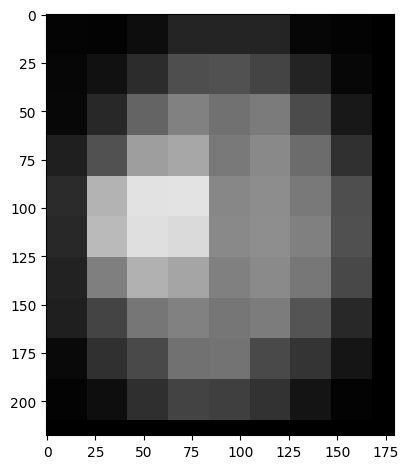

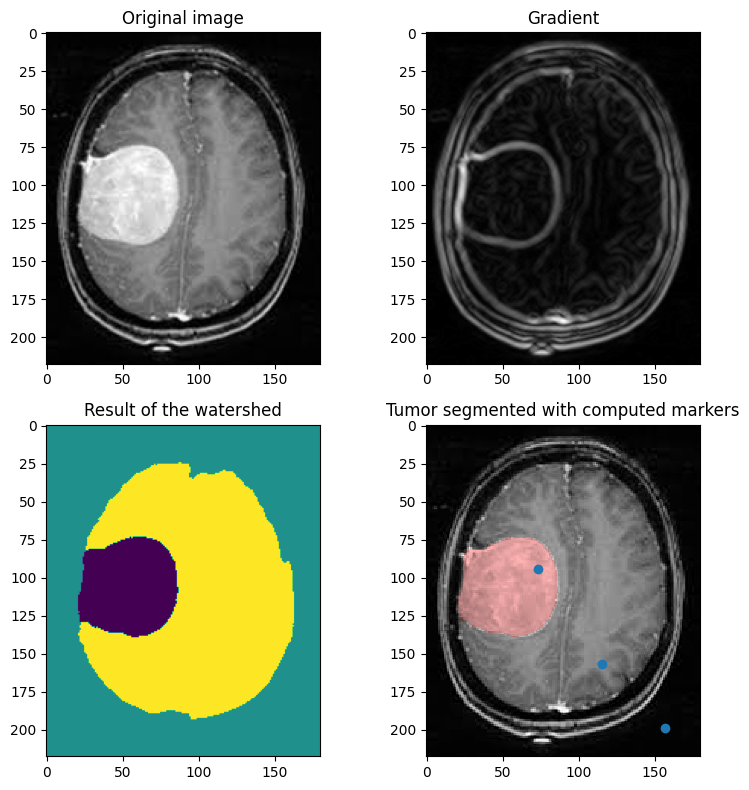

In [19]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, gray2rgb, hsv2rgb
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed

im = imread('mri_brain.jpg')
im = rgb2gray(im)

## -- Idea : Use a watershed with automatic markers -- ##

smoothing_factor = 3
gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))

markers_coordinates = np.zeros((1,1))
markers_coordinates = set_markers(im)

Vx, Vy = scat_markers(markers_coordinates)

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(gradient, markers)
# imshow(markers) 

zone = (ws==1)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray);
plt.title('Gradient')
plt.subplot(2,2,3)
plt.imshow(ws);
plt.title('Result of the watershed')
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));
plt.title('Tumor segmented with computed markers')
plt.scatter(Vx,Vy);

im = gray2rgb(im)
im = rgb2hsv(im)

for i in range(im.shape[0]):
    for j in range(im.shape[1]): 
        if(zone[i,j]):
            im[i,j,0] = 270
            im[i,j,1] = 0.3

im = hsv2rgb(im)
imshow(im)

## -- Compute the area -- ## 
    # Number of pixel in the tumor : 

pix = ( ws == 1 ).sum()

    #Area per pixel 

SurfElem = 0.115 * 0.115 

area = pix*SurfElem

print('The tumor has a surface of ', area, 'cm²')

